<a href="https://colab.research.google.com/github/emilyj19/TS/blob/master/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_path = 'gdrive/My Drive/FinancialTS/JPmarket_dataset.npz' 
data = np.load(root_path)

In [5]:
data.files

['train_ratios', 'test_ratios', 'train_volumes', 'test_volumes']

In [0]:
train_ratios = data['train_ratios']
test_ratios = data['test_ratios']
train_vols = data['train_volumes']
test_vols = data['test_volumes']

In [10]:
test_ratios.shape

(499, 61, 64)

In [0]:
#loss function here 
def ModelLoss(actual, pred, N):
  square_loss_matrix = np.square(actual[:,N:] - pred)
  loss = np.mean(np.mean(np.mean(square_loss_matrix, axis = 2), axis = 1))
  return loss

In [0]:
def MovingAverage(data, N):
  no_stocks, days, bins = data.shape
  pred_MA = np.zeros((no_stocks,days-N,bins))
  for s in range(no_stocks):
    for d in range(N, days): 
      for t in range(bins): 
        pred_t = np.mean(train_ratios[s,d-N:d,t])
        pred_MA[s,d-N,t] = pred_t
        
  loss = ModelLoss(data, pred_MA, N)
  
  return pred_MA, loss 

def ExpMovingAverage(data, N): 
  no_stocks, days, bins = data.shape
  pred_EMA = np.zeros((no_stocks,days-N,bins))
  k = 2/(N+1)
  for s in range(no_stocks):
    for d in range(N, days): 
      for t in range(bins): 
        if (d - N) == 0: 
          pred_t = np.mean(data[s,d-N:d,t])
          pred_EMA[s,d-N,t] = pred_t
        else: 
          pred_t = (1-k)*pred_EMA[s,d-1-N,t] + k*data[s,d,t]
          pred_EMA[s,d-N,t] = pred_t
  
  loss = ModelLoss(data, pred_EMA, N)
  
  return pred_EMA, loss 
          

In [33]:
print('EMA', ExpMovingAverage(train_ratios[:1], 30)[1])
print('MA', MovingAverage(train_ratios[:1], 180)[1])

EMA 0.00022277347583647317
MA 0.0002681475696562265


In [13]:
pip install gluonts

In [0]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.util import to_pandas


In [0]:
#split data into new sequences
def split_data(n_days, data): #data for one stock in the form [days, bins]
  no_ts = data.shape[0]-n_days
  length_ts = n_days*data.shape[1]
  new_data = np.zeros((no_ts,length_ts))
  for j in range(no_ts):
    for i in range(n_days): 
      new_data[j,64*i:64*i + 64] = data[j+i,:]
  
  return new_data

In [8]:
#create test data sequence, needs to be same length as the training data for the LSTM input 
#first need to concatenate the train and test arrays 
def make_test_data(train_data, test_data, n_days, stock_index):
  all_data = np.concatenate((train_data, test_data), axis = 1)
  
  one_data = all_data[stock_index]
  
  #now want to take only sets of n_days which contain the test data too 
  no_ts = test_data.shape[1]
  length_ts = n_days*one_data.shape[1]
  new_data = np.zeros((no_ts, length_ts))
  
  for j in range(no_ts): 
    for i in range(n_days): 
      new_data[j, 64*i:64*i + 64] = one_data[train_data.shape[1]+j-180+i+1,:]
      
  return new_data
  
all_ratios = np.concatenate((train_ratios, test_ratios), axis = 1)
print('all', all_ratios.shape)
print('train', train_ratios.shape)
print('test', test_ratios.shape)


testing_ratios = make_test_data(train_ratios, test_ratios, 180, 0)


all (499, 523, 64)
train (499, 462, 64)
test (499, 61, 64)


In [0]:
training_data = split_data(180, train_ratios[0])
training_data_volume = split_data(180, train_vols[0])

#normalize volume data
train_volume = training_data_volume/np.amax(train_vols[0])


In [41]:
training_data2 = np.concatenate((training_data, np.zeros((282, 11520))), axis = 1)
training_data2.shape

(282, 23040)

In [0]:
start = pd.Timestamp("01-01-2019", freq='5min')
prediction_length = 64
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = [{'target': x, 'start': start} for x in train_volume[:, :-prediction_length]]
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = [{'target': x, 'start': start} for x in train_volume]


In [0]:
estimator = DeepAREstimator(freq = "5min", prediction_length = 64, trainer = Trainer(epochs = 5))
predictor = estimator.train(training_data = train_ds)


In [94]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=64,
    context_length=100,
    freq="5min",
    trainer=Trainer(epochs=5),
)

predictor = estimator.train(train_ds)

I0618 11:30:46.388537 140407316592512 _base.py:188] Start model training
I0618 11:30:46.404713 140407316592512 _base.py:201] Number of parameters in SimpleFeedForwardTrainingNetwork: 643
I0618 11:30:46.406683 140407316592512 _base.py:242] Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 50.43it/s, avg_epoch_loss=-2.38]
I0618 11:30:47.402211 140407316592512 _base.py:285] Epoch[0] Elapsed time 0.994 seconds
I0618 11:30:47.403441 140407316592512 _base.py:294] Epoch[0] Evaluation metric 'epoch_loss'=-2.379890
I0618 11:30:47.413158 140407316592512 _base.py:242] Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 76.22it/s, avg_epoch_loss=-2.72]
I0618 11:30:48.079746 140407316592512 _base.py:285] Epoch[1] Elapsed time 0.664 seconds
I0618 11:30:48.081635 140407316592512 _base.py:294] Epoch[1] Evaluation metric 'epoch_loss'=-2.715229
I0618 11:30:48.089477 140407316592512 _base.py:242] Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.0

In [0]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_eval_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

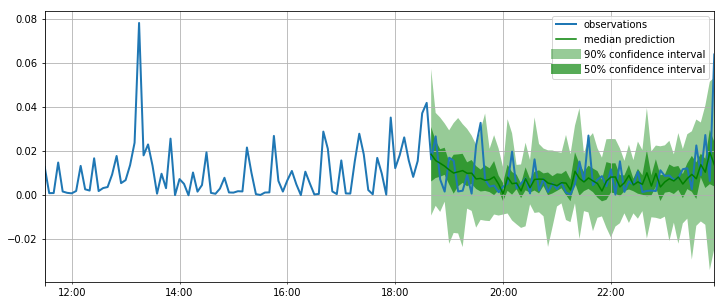

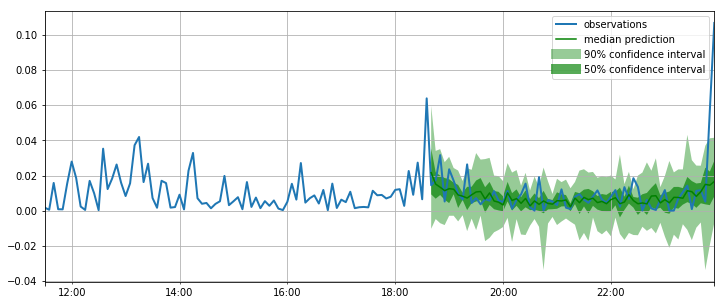

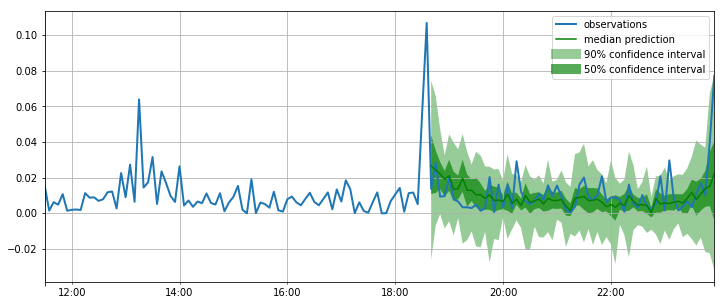

In [96]:
from itertools import islice

def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

plot_forecasts(tss, forecasts, past_length=150, num_plots=3)

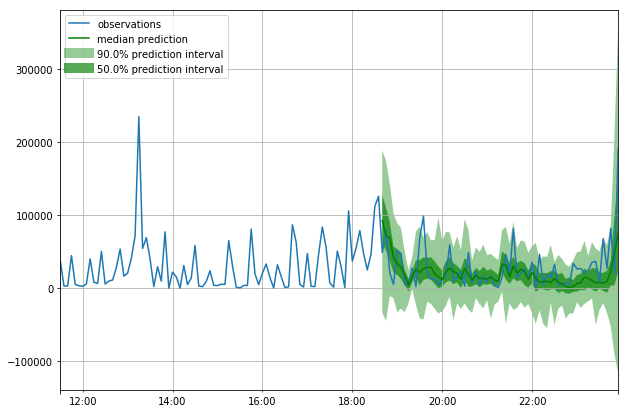

In [85]:
plot_length = 150 
prediction_intervals = (50.0, 90.0)
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
tss[0][-plot_length:].plot(ax=ax)  # plot the time series
forecasts[10].plot(prediction_intervals=prediction_intervals, color='g')
plt.grid(which="both")
plt.legend(legend, loc="upper left")
plt.show()

In [97]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.5], seasonality=2016)

agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
agg_metrics

Running evaluation: 100%|██████████| 282/282 [00:02<00:00, 130.21it/s]


{'Coverage[0.5]': 0.5562943262411347,
 'MAE_Coverage': 0.05629432624113473,
 'MASE': 0.6809738657958437,
 'MSE': 0.0007099461705155451,
 'MSIS': 27.23895463183373,
 'ND': 0.7956128006653517,
 'NRMSE': 1.6704459849917295,
 'QuantileLoss[0.5]': 229.03988537772716,
 'RMSE': 0.02664481507752578,
 'abs_error': 229.03988537772716,
 'abs_target_mean': 0.01595071933897803,
 'abs_target_sum': 287.87858262987555,
 'mean_wQuantileLoss': 0.7956128006653517,
 'sMAPE': 0.9167874651514292,
 'seasonal_error': 0.018912434274175903,
 'wQuantileLoss[0.5]': 0.7956128006653517}

In [66]:
forecast_values = forecasts[0].samples
forecast_values.shape

(100, 64)

In [10]:
pip install torch

In [0]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [24]:
#LSTM 

#separate data into x and y 
x_train = training_data[:,:-64]
y_train = training_data[:, -64:]
x_test = testing_ratios[:,:-64]
y_test = testing_ratios[:,-64:]

X_train = torch.FloatTensor(x_train)
X_train = X_train.view(179, 282, 64)
Y_train = torch.FloatTensor(y_train)

X_test = torch.FloatTensor(x_test)
X_test = X_test.view(-1,x_test.shape[0],64)
Y_test = torch.FloatTensor(y_test)

batch_size_ = 50
learning_rate = 0.001
hidden_units_ = 32

class LSTM(nn.Module): 
  
  def __init__(self, input_size, hidden_size, batch_size, output_size, num_layers = 1): 
    super(LSTM, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.batch_size = batch_size
    self.output_size = output_size
    self.num_layers = num_layers
    
    self.lstm = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    
    self.linear = nn.Linear(self.hidden_size, self.output_size)
    
  def init_hidden(self): 
    return (torch.zeros(self.num_layers, self.batch_size, self.hidden_size),
              torch.zeros(self.num_layers, self.batch_size, self.hidden_size))

  def forward(self, input_data): 
    #print('input', input_data.shape)
    lstm_out, self.hidden = self.lstm(input_data.view(len(input_data), self.batch_size, -1))
    y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))

    return y_pred#.view(-1)
    
    
model = LSTM(X_train.shape[2], hidden_units_, batch_size_, y_train.shape[1])
print(model)
    
  

LSTM(
  (lstm): LSTM(64, 32)
  (linear): Linear(in_features=32, out_features=64, bias=True)
)


In [25]:
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 50

dataset_train = TensorDataset(X_train.view(X_train.shape[1], -1, 64), Y_train)
dataset_test = TensorDataset(X_test.view(X_test.shape[1], -1, 64), Y_test)

# Train model

train_loss = []
test_loss = []

train_loader = DataLoader(dataset_train, batch_size= batch_size_, shuffle = True, drop_last = True)
iterator = iter(train_loader)

test_loader = DataLoader(dataset_test, batch_size= batch_size_, shuffle = True, drop_last = True)
test_iterator = iter(test_loader)

for t in range(num_epochs): 
  model.zero_grad()
  
  for x_batch, y_batch in train_loader:
    
    model.hidden = model.init_hidden()
    X_batch = x_batch.view(x_batch.shape[1], -1, 64)
    y_pred = model(X_batch) 
    loss = loss_function(y_pred, y_batch)
    
    if t % 10 == 0:
      print("Epoch ", t, "MSE: ", loss.item())
    
    train_loss.append(loss.item())
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
    
  
  with torch.no_grad(): 
    for x_batch_test, y_batch_test in test_loader:
      model.eval()
      
      X_batch_test = x_batch_test.view(x_batch_test.shape[1], -1, 64)
      
      y_pred_test = model(X_batch_test)
      
      loss_test = loss_function(y_pred_test, y_batch_test)
      test_loss.append(loss_test.item())
      
      if t % 10 == 0:
        print("Epoch ", t, "test MSE: ", loss_test.item())
      


Epoch  0 MSE:  0.014557799324393272
Epoch  0 MSE:  0.013738510198891163
Epoch  0 MSE:  0.012881556525826454
Epoch  0 MSE:  0.012231023982167244
Epoch  0 MSE:  0.011594249866902828
Epoch  0 test MSE:  0.010680478997528553
Epoch  10 MSE:  0.00030595145653933287
Epoch  10 MSE:  0.00039628372178412974
Epoch  10 MSE:  0.0003320453397464007
Epoch  10 MSE:  0.00027073564706370234
Epoch  10 MSE:  0.000279408588539809
Epoch  10 test MSE:  0.00019241226254962385
Epoch  20 MSE:  0.00030491413781419396
Epoch  20 MSE:  0.0002795948530547321
Epoch  20 MSE:  0.00023754945141263306
Epoch  20 MSE:  0.0002862823021132499
Epoch  20 MSE:  0.0002681447076611221
Epoch  20 test MSE:  0.0001620822149561718
Epoch  30 MSE:  0.00028738976106978953
Epoch  30 MSE:  0.0002873968333005905
Epoch  30 MSE:  0.0002659223973751068
Epoch  30 MSE:  0.00022192343021743
Epoch  30 MSE:  0.0002820666413754225
Epoch  30 test MSE:  0.00016144398250617087
Epoch  40 MSE:  0.0002641569299157709
Epoch  40 MSE:  0.0002721837663557380

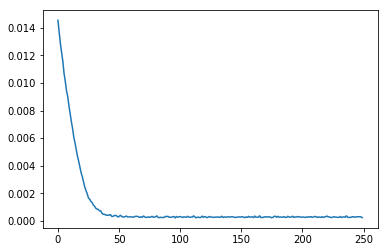

In [26]:
plt.plot(train_loss)

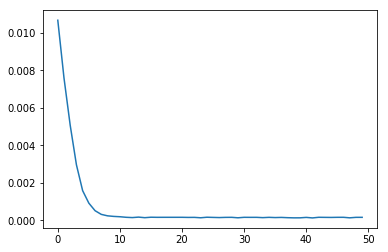

In [27]:
plt.plot(test_loss)

tensor([0.9957, 1.0010, 1.0014, 1.0245, 0.9702, 1.0053, 1.0113, 1.0076, 1.0119,
        0.9763, 1.0203, 0.9857, 1.0112, 0.9714, 1.0024, 0.9914, 1.0109, 1.0010,
        0.9998, 0.9839, 1.0072, 0.9808, 1.0028, 0.9861, 1.0351, 0.9890, 1.0000,
        0.9776, 0.9935, 0.9991, 1.0064, 0.9845, 1.0022, 0.9859, 0.9881, 1.0155,
        1.0163, 1.0235, 0.9966, 1.0006, 1.0075, 0.9857, 0.9905, 1.0043, 1.0092,
        0.9920, 0.9876, 0.9930, 1.0073, 1.0237, 1.0066, 0.9995, 1.0105, 0.9931,
        0.9944, 1.0009, 1.0024, 1.0223, 1.0016, 1.0015, 0.9972, 1.0032, 0.9975,
        0.9949, 1.0015, 1.0139, 1.0131, 1.0198, 0.9811, 1.0079, 1.0165, 0.9863,
        0.9933, 1.0159, 1.0071, 1.0010, 1.0040, 1.0008, 0.9734, 0.9936, 0.9863,
        1.0223, 1.0182, 0.9988, 0.9899, 0.9963, 1.0084, 0.9928, 0.9969, 0.9801,
        0.9941, 0.9913, 0.9920, 0.9983, 1.0082, 1.0216, 1.0081, 0.9583, 1.0131,
        1.0026, 1.0030, 1.0165, 0.9800, 0.9962, 1.0053, 0.9935, 1.0048, 1.0238,
        0.9675, 1.0220, 1.0057, 1.0450, 